In [1]:
import os
import argparse
import importlib
import map_util
import numpy as np
import matplotlib.pyplot as plt

import shapely
from shapely.ops import split
from shapely.geometry import Polygon, LineString, Point

BASE_DIR = !git rev-parse --show-toplevel
BASE_DIR = os.path.abspath(*BASE_DIR)
print(f"BASE DIR = {BASE_DIR}")
os.chdir(BASE_DIR)

BASE DIR = /home/ps2958/pps-election


# Utility function

In [2]:
def get_rotation_matrix(theta):
    """
    Set theta>0 for counter-clockwise rotation.
    Set theta<0 for clockwise rotation.
    Transpose rotation matrix to reverse rotation.
    """
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [3]:
MAP_LIST    = map_util.list_maps(map_util.MAP_DIRS+"/tournaments")
LOADED_MAPS = [map_util.load_map(map_file) for map_file in MAP_LIST]

In [4]:
def visualize_map(_map, ax=None, color_scheme='argmax'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
    
    if color_scheme == 'argmax':
        colors = np.argmax(_map[:, 2:], 1)
    else:
        colors = [tuple(dist) for dist in _map[:, 2:]]

    plot = ax.scatter(_map[:,0], _map[:,1], s=0.01, c=colors, alpha=0.5, cmap='rainbow')

# 2 party 1 elector with voter count tolerance

In [5]:
def find_two_split_with_tolerance(location, winners, target, voter_tolerance=25, resolution=300, MYPARTY=0, return_top=True, debug=False):
    
    if target is None:
        target = (winners==MYPARTY).mean()

    # Calculate voter numbers required
    num_voters = len(location) // 2
    min_voters = num_voters - voter_tolerance
    max_voters = num_voters + voter_tolerance
    
    # Initial number of winners
    init_wins = (winners==MYPARTY).sum()
    
    # Output statistics
    thetas  = np.linspace(0, np.pi, resolution)
    ratios1 = np.zeros_like(thetas)
    ratios2 = np.zeros_like(thetas)
    idxes   = np.zeros_like(thetas, dtype=int)
    
    if target < 0.5:
        # If it is less than 50%, split such that one district has 50% or more votes
        for i, theta in enumerate(thetas):
            R = get_rotation_matrix(theta)
            new_locs = location @ R.T
            
            # Boundary line is x=x'
            sortidx = new_locs[:, 0].argsort()
            
            winner_counts = np.arange(min_voters, max_voters)
            poly1_winners = (winners[sortidx] == MYPARTY).cumsum()[min_voters: max_voters]
            poly2_winners = init_wins - poly1_winners
            
            poly1_ratio = poly1_winners / winner_counts
            poly2_ratio = poly2_winners / winner_counts[::-1]
            
            p1_idx, p2_idx = poly1_ratio.argmax(), poly2_ratio.argmax()
            p1_max, p2_max = poly1_ratio[p1_idx], poly2_ratio[p2_idx]
            
            idxes[i]   = min_voters + (p1_idx if p1_max > p2_max else p2_idx)
            ratios1[i] = poly1_ratio[idxes[i] - min_voters]
            ratios2[i] = poly2_ratio[idxes[i] - min_voters]
            
        print(ratios1.max(), ratios2.max())

        # Calculate threshold for heuristic function
        thresh = min(max(ratios1.max(), ratios2.max()), 0.51)
    
    else:
        # Else try hard to maintain district proportion
        for i, theta in enumerate(thetas):
            R = get_rotation_matrix(theta)
            new_locs = location @ R.T
            
            # Boundary line is x = x'
            sortidx = new_locs[:, 0].argsort()
            
            winner_counts = np.arange(min_voters, max_voters)
            poly1_winners = (winners[sortidx] == MYPARTY).cumsum()[min_voters: max_voters]
            poly2_winners = init_wins - poly1_winners
            
            poly1_ratio = poly1_winners / winner_counts
            poly2_ratio = poly2_winners / winner_counts[::-1]
            
            thresh = 0.50
            delta = 10. * (poly1_ratio < thresh) + 10. * (poly2_ratio < thresh)
            delta = ((poly1_ratio < target) + 1) * np.abs(poly1_ratio - target)
            delta = ((poly2_ratio < target) + 1) * np.abs(poly2_ratio - target)
            
            idxes[i]   = delta.argmin()
            ratios1[i] = poly1_ratio[idxes[i]]
            ratios2[i] = poly2_ratio[idxes[i]]
            idxes[i]  += min_voters
        
        # Threshold for heuristic function is simply majority
        thresh = 0.50

    deltas = 10. * (ratios1 < thresh) + 10. * (ratios2 < thresh)

    # Penalties for differences to target
    deltas += ((ratios1<target) + 1) * np.abs(ratios1-target)
    deltas += ((ratios2<target) + 1) * np.abs(ratios2-target)

    if debug:
        return thetas, deltas, ratios1, ratios2

    if return_top:
        min_idx = deltas.argmin()
        
        print(f"Found Δ={deltas[min_idx]:0.5f} at θ={thetas[min_idx]:0.5f} "
              f"xp_idx={idxes[min_idx]}. Split=[{ratios1[min_idx]:0.3f} {ratios2[min_idx]:0.3f}]")

        return thetas[min_idx], int(idxes[min_idx]) # TODO: Verify types

    top_deltas = deltas.argsort()[:10]
    return thetas[top_deltas], deltas[top_deltas], ratios1[top_deltas], ratios2[top_deltas]

In [6]:
def split_polygon(xp, theta, polygon):
    """
    Helper function.
    Given a polygon and a theta, divides the polygon into two districts based on theta
    """
    R = get_rotation_matrix(theta)
    
    rp = Polygon(np.dstack(polygon.exterior.xy)[0] @ R.T)
    x_min, y_min, x_max, y_max = rp.bounds
    
    """ Has form x = xp """
    liney = LineString([[xp, y_min], [xp, y_max]] @ R)

    poly1, poly2 = shapely.ops.split(polygon, liney)
    
    return poly1, poly2

In [7]:
def recursively_split_twos(location, winners, polygon, voter_tolerance=25, num_splits=8, resolution=1000, MYPARTY=0):
    """
    Splits a district into two equal halves with same proportion with a penalty for < 0.50
    Outperforms recursively_split_threes
    """
    target = (winners==MYPARTY).mean()
    if num_splits==0:
        return int(target >= 0.50), [polygon]
    
    print()
    print("Target = ", target)
    
    # Finds the best-split line x=xp rotated about theta
    theta, xp_idx = find_two_split_with_tolerance(location, winners, target,
            voter_tolerance=voter_tolerance, resolution=resolution, MYPARTY=MYPARTY)
    
    # Calculate xp and split voter locations/preferences
    R = get_rotation_matrix(theta)
    new_locs = location @ R.T
    sorted_idx = new_locs[:, 0].argsort()
    xp = new_locs[sorted_idx[xp_idx], 0]
    
    poly1, poly2 = split_polygon(xp, theta, polygon)
    
    location1, winners1 = location[sorted_idx[:xp_idx+1]], winners[sorted_idx[:xp_idx+1]]
    location2, winners2 = location[sorted_idx[xp_idx+1:]], winners[sorted_idx[xp_idx+1:]]
    
    if poly1.contains(Point(*location2[0])):
        poly1, poly2 = poly2, poly1

    print(f"Found split θ={np.degrees(theta):0.2f} splits={[(winners1==MYPARTY).mean(), (winners2==MYPARTY).mean()]}")
    
    left_wins,  left_polygons  = recursively_split_twos(location1, winners1, poly1, voter_tolerance, num_splits-1, resolution, MYPARTY)
    right_wins, right_polygons = recursively_split_twos(location2, winners2, poly2, voter_tolerance, num_splits-1, resolution, MYPARTY)
    
    return left_wins + right_wins, left_polygons + right_polygons

# District Generation Script

[111122 110803 111408]


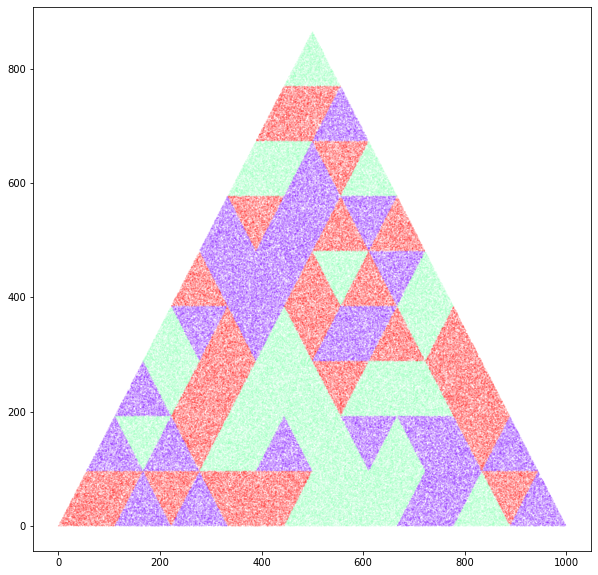

In [35]:
mmap = LOADED_MAPS[1]
visualize_map(mmap)

print(np.bincount(mmap[:,2:].argmax(1)))

In [39]:
# Code to generate 256 districts with 1 elector scheme
location, winners = mmap[:,:2], mmap[:,2:].argmax(1)
polygon   = Polygon([[0,0], [1000,0], [500,500*np.sqrt(3)]])

num_splits = 6
voter_tolerance = np.floor(0.1 * 333333/(2**num_splits) / num_splits).astype(int)
win_counts, districts = recursively_split_twos(
    location, winners, polygon, voter_tolerance, num_splits, resolution=1000, MYPARTY=1)
print(win_counts)


Target =  0.3324093324093324
0.3701662428633114 0.422092422950859
Found Δ=10.26886 at θ=2.17616 xp_idx=166749. Split=[0.243 0.422]
Found split θ=124.68 splits=[0.24281859070464767, 0.4220898891243404]

Target =  0.24281859070464767
0.3261819578841213 0.2783560854374527
Found Δ=10.24976 at θ=2.15729 xp_idx=83294. Split=[0.326 0.160]
Found split θ=123.60 splits=[0.3261780418992737, 0.1596189563237673]

Target =  0.3261780418992737
0.3913284088448305 0.360554365871851
Found Δ=10.19489 at θ=1.43400 xp_idx=41561. Split=[0.391 0.261]
Found split θ=82.16 splits=[0.39131899331119774, 0.2613040040255913]

Target =  0.39131899331119774
0.5621647741000242 0.4989694674783109
Found Δ=10.35456 at θ=0.10692 xp_idx=20698. Split=[0.510 0.273]
Found split θ=6.13 splits=[0.51012126189671, 0.2734506063365767]

Target =  0.51012126189671
Found Δ=0.00010 at θ=0.75159 xp_idx=10429. Split=[0.510 0.510]
Found split θ=43.06 splits=[0.510162991371045, 0.5100788781770377]

Target =  0.510162991371045
Found Δ=0.0

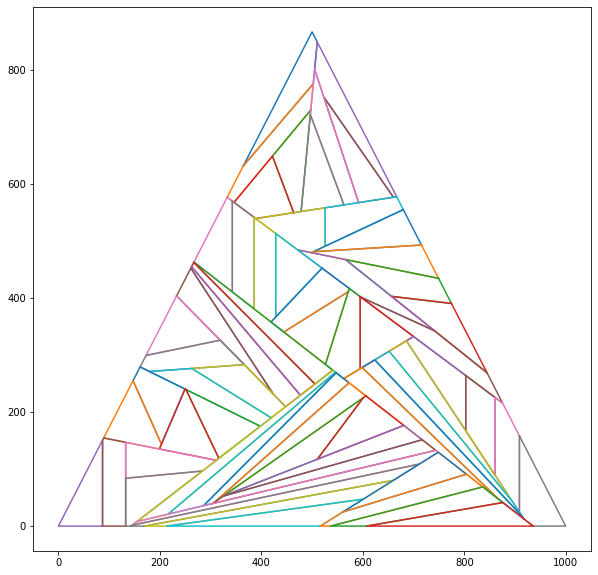

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

colors  = winners
# plot = ax.scatter(*location.T, s=0.01, c=winners, alpha=0.5, cmap='rainbow')

for district in districts:
    plt.plot(*district.exterior.xy)

# Save to dat file

In [41]:
num_voters, num_parties = 333333, 2

district_boundaries = [
    [len(district.boundary.coords)] + [p for x in district.boundary.coords for p in x] 
    for district in districts
]
num_districts = len(district_boundaries)

fmt_boundary = []
for boundary in district_boundaries:
    fmt_boundary.append(str(boundary[0]) + " " + "".join(map(lambda x:f"{x:f} ", boundary[1:])))

with open(f"tour3_64districts_party2.dat", "w") as handle:
    np.savetxt(handle, mmap, fmt="%f", delimiter=' ', header=f"{num_voters} {num_parties}", comments='')
    np.savetxt(handle, np.array(fmt_boundary), fmt="%s", header=f"{num_districts}", comments='')